In [1]:
# import libraries
import numpy as np
import nmrglue as ng
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
from collections import OrderedDict
from glob import glob
print("nmrglue version is %s" % ng.__version__)

nmrglue version is 0.8


In [2]:
directory_names = list(sorted(glob("Styrenyl_RecoveredSM_80%conversion/*")))
print(directory_names)

['Styrenyl_RecoveredSM_80%conversion/200', 'Styrenyl_RecoveredSM_80%conversion/201', 'Styrenyl_RecoveredSM_80%conversion/202', 'Styrenyl_RecoveredSM_80%conversion/203', 'Styrenyl_RecoveredSM_80%conversion/204', 'Styrenyl_RecoveredSM_80%conversion/205', 'Styrenyl_RecoveredSM_80%conversion/206', 'Styrenyl_RecoveredSM_80%conversion/207', 'Styrenyl_RecoveredSM_80%conversion/208', 'Styrenyl_RecoveredSM_80%conversion/209', 'Styrenyl_RecoveredSM_80%conversion/210', 'Styrenyl_RecoveredSM_80%conversion/211', 'Styrenyl_RecoveredSM_80%conversion/212', 'Styrenyl_RecoveredSM_80%conversion/213', 'Styrenyl_RecoveredSM_80%conversion/214', 'Styrenyl_RecoveredSM_80%conversion/215', 'Styrenyl_RecoveredSM_80%conversion/216', 'Styrenyl_RecoveredSM_80%conversion/217', 'Styrenyl_RecoveredSM_80%conversion/218', 'Styrenyl_RecoveredSM_80%conversion/219']


In [3]:
# read NMR data
processed_spectra = []
ppm_scales = []
n_complex_points = None
sequence_name=None
for directory_name in directory_names:
    print("Reading from %s..." % directory_name, end='')
    dic, spectra = ng.bruker.read_pdata(directory_name + "/pdata/1", bin_files=["2rr","2ii"])
    print("parsing...", end='')

    if sequence_name is None:
        sequence_name = dic["acqus"]["PULPROG"]
    elif sequence_name != dic["acqus"]["PULPROG"]:
        raise ValueError("unexpected sequence name: %s" % dic["acqu2s"]["PULPROG"])
    
    real_part = spectra[0]
    imaginary_part = spectra[1]
    
    n_spectra = len(real_part)
    for i in range(n_spectra):
        real_spectrum = real_part[i]
        imaginary_spectrum = imaginary_part[i]
        
        if np.sum(real_spectrum) == 0.0:
            print("found blank spectrum and skipping rest...", end='')
            break
            
        complex_spectrum = real_part[i]+1j*imaginary_part[i]
        processed_spectra.append(complex_spectrum)
        
        udic = ng.bruker.guess_udic(dic,complex_spectrum)
        uc = ng.fileiobase.uc_from_udic(udic)
        ppm = uc.ppm_scale()
        ppm_scales.append(ppm)
        
    print('done.  %d spectra now loaded.' % len(processed_spectra))

delay_time = dic["acqus"]["D"][1]
n_points = np.shape(processed_spectra[0])[0]
sw_hz = dic["acqus"]["SW_h"]

print("Loaded %d FIDs (%d points, sweep width = %d Hz, delay = %d s, sequence = \'%s\')." % \
    (len(processed_spectra), n_points, sw_hz, delay_time, sequence_name))


Reading from Styrenyl_RecoveredSM_80%conversion/200...parsing...found blank spectrum and skipping rest...done.  16 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/201...parsing...found blank spectrum and skipping rest...done.  32 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/202...parsing...found blank spectrum and skipping rest...done.  48 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/203...parsing...found blank spectrum and skipping rest...done.  64 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/204...parsing...found blank spectrum and skipping rest...done.  80 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/205...parsing...found blank spectrum and skipping rest...done.  96 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/206...parsing...found blank spectrum and skipping rest...done.  112 spectra now loaded.
Reading from Styrenyl_RecoveredSM_80%conversion/207...

In [4]:
# apply additional phasing
spectrum_number = 0
spectrum = processed_spectra[spectrum_number]
p0 = 0.0
p1 = 0.0
phased_spectrum = ng.proc_base.ps(spectrum, p0=-p0, p1=-p1)
ppm = ppm_scales[spectrum_number]
ppm_max, ppm_min = ppm[-1], ppm[0]

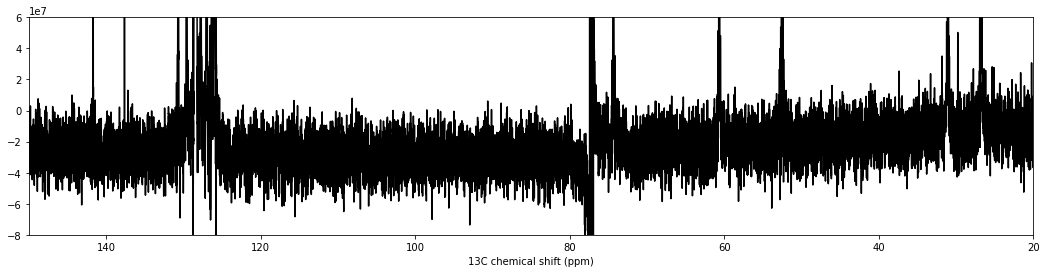

In [5]:
plt.figure(figsize=(18,4))
real_spectrum = np.real(phased_spectrum)
plt.plot(ppm,real_spectrum,"k")
plt.xlim(ppm_max,ppm_min)
y_max = np.max(real_spectrum)
y_min = np.min(real_spectrum)
y_range = y_max-y_min
#plt.ylim(y_min-y_range*0.001,y_min+y_range*0.001)
plt.xlim(150,20)
plt.ylim(-5e9,5e10)
plt.ylim(-8e7,6e7)
#plt.xlim(ppm_max,ppm_min)
plt.xlabel("13C chemical shift (ppm)")
plt.show()

In [6]:
# define phases piecewise
# indices are spectrum indices, phase_list is 2-tuples of (p0,p1)
# must include first and last indices and should be sequential
phase_dictionary = {0:(0.0,0.0), len(processed_spectra)-1:(0.0,0.0)}
phase_dictionary = OrderedDict(phase_dictionary)
assert(0 in phase_dictionary and (len(processed_spectra)-1) in phase_dictionary)
phase_list_indices = list(phase_dictionary.keys())
phase_list = [ phase_dictionary[i] for i in phase_list_indices ]

In [7]:
# piecewise linearly interpolate the phase list
all_indices = np.array(range(len(processed_spectra)))
p0_points = [ i[0] for i in phase_list ]
p1_points = [ i[1] for i in phase_list ]
p0_interpolated = np.interp(all_indices, phase_list_indices, p0_points)
p1_interpolated = np.interp(all_indices, phase_list_indices, p1_points)

In [8]:
processed_spectra_adjusted = []
print("Processing...")
for i,spectrum in enumerate(processed_spectra):
    print("%5d of %5d \r" % (i+1, len(processed_spectra)), end='')
    p0 = p0_interpolated[i]
    p1 = p1_interpolated[i]
    processed_spectrum = ng.proc_base.ps(spectrum, p0=-p0, p1=-p1)
    processed_spectra_adjusted.append(processed_spectrum)
print("\n...done!")
processed_spectra = processed_spectra_adjusted

Processing...
  320 of   320 
...done!


In [9]:
# create functions for individual peak phasing and integration
def find_index(ppm, this_ppm):
    interval = ppm[1]-ppm[0]
    return int(np.ceil((this_ppm-ppm[0])/interval))

def cphase(angle):
    return np.exp(1j*np.radians(angle))

In [10]:
# define peaks and phases here
# (larger chemical shift, smaller chemical shift)
peak_names = ["benzylic","vinylic","ortho(ak)","ortho(o)","meta(o)",
              "meta(ak)","para(ak)","para(o)","solvent peak","carbonyl",
              "reference peak","alpha","allylic","beta","ester methyl"]
peaks = [(130.880,130.475),(129.723,129.459),(128.627,128.431),(128.430,128.245),(127.899,127.645),
        (127.140,126.878),(126.452,126.169),(126.168,125.900),(77.7,76.6),(74.496,74.228),
         (60.789,60.522),(52.686,52.431),(31.166,30.919),(26.917,26.684),(14.240,13.979)]
phases = [1.0,-1.0,-1.5,-1.0,1.5,
          0.0,0.5,1.0,0.0,-0.5,
          -1.0,0.0,0.5,-0.5,1.0]
cphases = [ cphase(i) for i in phases ]

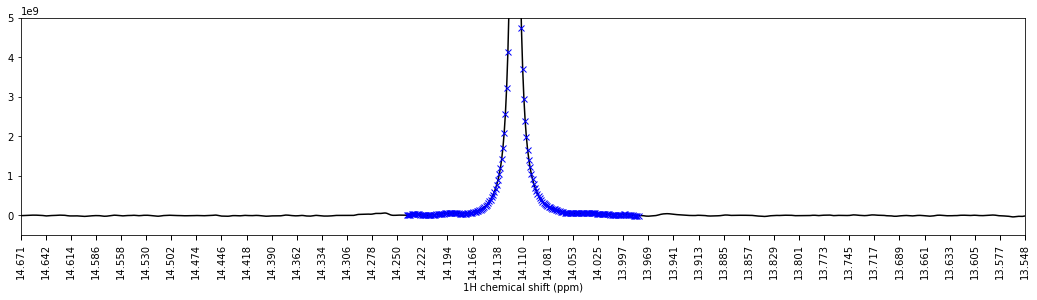

In [11]:
# check phasing and integration range for each peak
spectrum_number = 300 #16+32*5 

# 8, 24, 40, 56, 72, 88, 104,
# 120, 136, 152, 168, 184, 200, 
# 216, 232, 248, 264, 280, 296, 312

peak_number = 14
#peak 8 is CDCl3

# gather information
peak = peaks[peak_number]
phase = cphases[peak_number]
phased_spectrum = np.real(processed_spectra[spectrum_number]*phase)
ppm = ppm_scales[spectrum_number]

# make plot
plt.figure(figsize=(18,4))
plt.plot(ppm, phased_spectrum, "k")

center = np.average(peak)
x_axis_range = max(peak[0]-peak[1]+0.3,0.3)
start = center+x_axis_range
end = center-x_axis_range
plt.xlim(start,end)
plt.ylim(y_min-y_range*0.001,y_min+y_range*0.01)
plt.ylim(-5e8,5e9)

peak_start = find_index(ppm,peak[0])
peak_end = find_index(ppm,peak[1])
if peak[0] <= peak[1]:
    print("check bigger chemical shift comes first")
peak_x = ppm[peak_start:peak_end]
peak_y = phased_spectrum[peak_start:peak_end]
plt.plot(peak_x,peak_y,"bx")

plt.xlabel("1H chemical shift (ppm)")
plt.xticks(np.linspace(end,start,41))

ax = plt.gca()
ax.get_xaxis().set_tick_params(length=5,direction='out', width=1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

(131072,)
(128.43, 128.245)


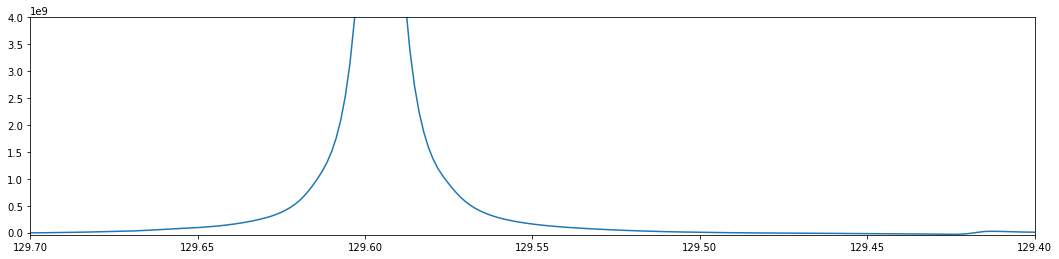

In [12]:
summed_spectra = np.array(processed_spectra)
summed_spectra = np.mean(summed_spectra,axis=0)
summed_spectra = np.real(summed_spectra)
print(np.shape(summed_spectra))
print(peaks[3])
plt.figure(figsize=(18,4))
plt.plot(ppm,summed_spectra)
plt.ylim(-4e7,4e9)
#plt.xlim(130,10)
plt.xlim(129.7,129.4)
plt.show()

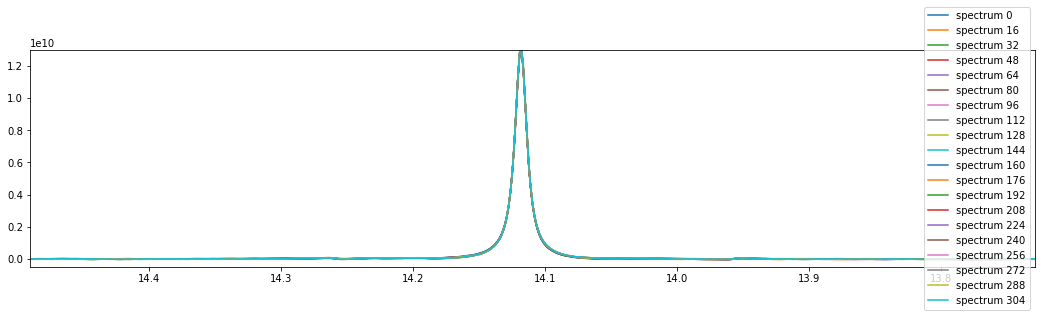

In [13]:
## overlay spectra
plt.figure(figsize=(18,4))
for i in range(0,len(processed_spectra),16):
    spectrum = np.real(processed_spectra[i])#-i*1e8
    ppm = ppm_scales[i]
    plt.plot(ppm,spectrum,label=("spectrum %d" % i))
peak_number = 14
plt.xlim(peaks[peak_number][0]+0.25,peaks[peak_number][1]-0.25)
plt.ylim(-5e8,1.3e10)
plt.legend(loc="right")
plt.show()

In [14]:
def compute_baseline(ppm, spectrum, order=1, clip_below = -6e7, clip_above = 2e7):
    noise_x = ppm.copy()
    noise_y = np.real(spectrum.copy())
    mask = np.ones(len(ppm), dtype=bool)
    for peak in peaks:
        index_low  = find_index(ppm,peak[1])
        index_high = find_index(ppm,peak[0])
        mask[index_low:index_high] = False
    noise_x = noise_x[mask]
    noise_y = noise_y[mask]
    noise_y = np.clip(noise_y, clip_below, clip_above)

    poly_coeff = np.polyfit(noise_x,noise_y,order)
    baseline_func = np.poly1d(poly_coeff)
    baseline = baseline_func(ppm)
    RMSE = np.sqrt(np.mean(np.square(noise_y-baseline_func(noise_x))))
    
    '''
    if plot:
        plt.figure(figsize=(18,4))
        plt.plot(ppm, np.real(spectrum), "k")
        plt.plot(ppm, baseline, "r")
        #plt.plot(noise_x,noise_y,"b")
        y_minus_limit = 1.25*clip_below if clip_below < 0.0 else 0.8*clip_below
        y_plus_limit = 1.25*clip_above if clip_above > 0.0 else 0.8*clip_above
        #plt.ylim(0,1e6)
        plt.ylim(y_minus_limit,y_plus_limit)
        plt.xlabel("1H chemical shift (ppm)")
        plt.xlim(ppm_max,ppm_min)
        plt.show()
    else:
        print "%.1E " % (RMSE / 1E5),
        for i in poly_coeff:
            print "%6.2f" % i,
        print
    '''
    
    return baseline
#compute_baseline(processed_spectra[0]);
baselines = [ compute_baseline(ppm,spectrum) for ppm,spectrum in zip(ppm_scales,processed_spectra) ]
subtracted_spectra = [ spectrum - baseline for spectrum, baseline in zip(processed_spectra,baselines) ]

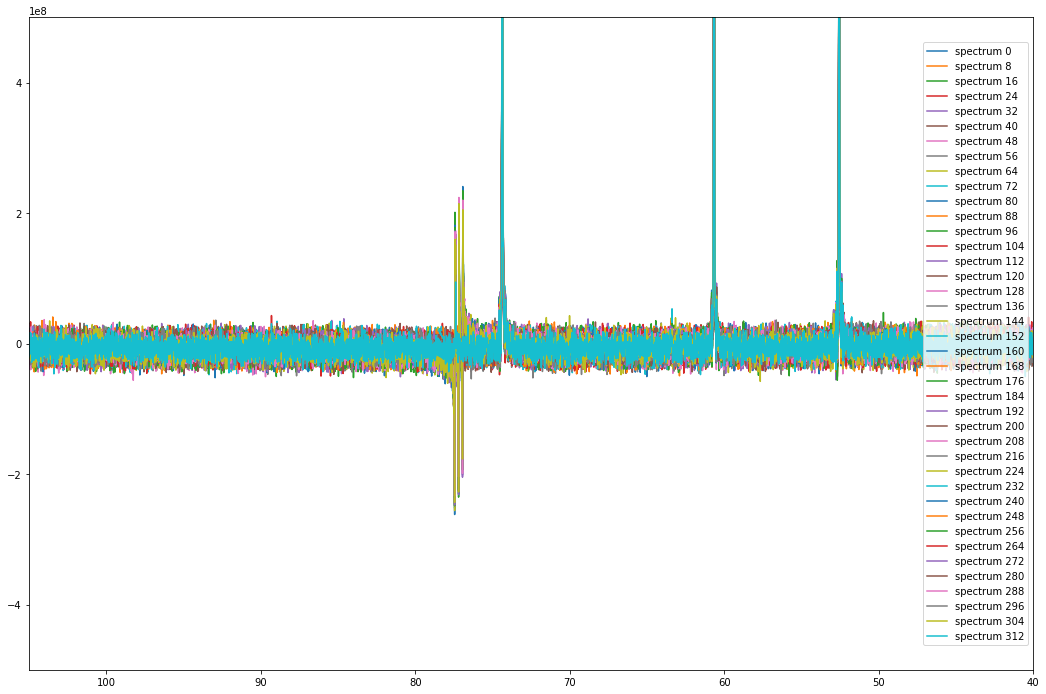

In [15]:
# overlay spectra
plt.figure(figsize=(18,12))
for i in range(0,len(subtracted_spectra),8):
    spectrum = np.real(subtracted_spectra[i])#+i*400
    ppm = ppm_scales[i]
    plt.plot(ppm,spectrum, label=("spectrum %d" % i))
plt.xlim(105,40)
plt.ylim(-5e8,5e8)
plt.legend(loc="right")
plt.show()

In [16]:
def compute_signal_to_noise(ppm, spectrum, noise=(110.0, 100.0), plot=False):
    xy = np.array([ppm,spectrum])
    min_value2 = find_index(ppm,noise[0])
    max_value2 = find_index(ppm,noise[1])
    y_noise  = np.real(xy[1,min_value2:max_value2])
    zero_level = np.mean(y_noise)

    signal_to_noise = []
    for i,peak in enumerate(peaks):
        min_value1 = find_index(ppm,peak[0])
        max_value1 = find_index(ppm,peak[1])
        y_signal = np.real(xy[1,min_value1:max_value1]*cphases[i])

        signal_level = np.max(y_signal - zero_level)/2.0
        noise_level  = np.sqrt(np.mean(np.square(y_noise-zero_level))) 
        signal_to_noise.append(signal_level / noise_level)
        
        if plot:
            print("%.2E %.2E" % (signal_level, noise_level))
            print(zero_level)
            plt.plot(x_signal,y_signal,"r")
            plt.plot(x_noise,y_noise,"b")
            #plt.ylim(-5E4,5E4)
            plt.show()

    return signal_to_noise

signal_to_noise_list = [ compute_signal_to_noise(ppm,spectrum) for ppm,spectrum in zip(ppm_scales,subtracted_spectra) ]
signal_to_noise = DataFrame(signal_to_noise_list)
experiment_numbers = [ i+1 for i in range(len(processed_spectra)) ]
signal_to_noise["run"] = experiment_numbers
signal_to_noise.set_index("run",drop=True,inplace=True)
peak_numbers = range(len(peaks))
peak_numbers = ["peak %02d" % (i+1) for i in peak_numbers]
signal_to_noise.columns = peak_numbers
#display(signal_to_noise)

avg_signal_to_noise = signal_to_noise.mean()
avg_signal_to_noise = avg_signal_to_noise.apply(lambda x : "%.0f" % x)
avg_signal_to_noise.name = "S/N"

display(avg_signal_to_noise)

peak 01     636
peak 02     597
peak 03    1228
peak 04    1095
peak 05     512
peak 06     504
peak 07    1140
peak 08    1294
peak 09       6
peak 10     650
peak 11     628
peak 12     612
peak 13     610
peak 14     541
peak 15     627
Name: S/N, dtype: object

In [17]:
# define function for integration
def integrate(ppm,spectrum, i, peak):
    index_low = find_index(ppm,peak[0])
    index_high = find_index(ppm,peak[1])
    return np.sum(np.real(spectrum[index_low:index_high]*cphases[i]))

In [18]:
results=[]
for ppm,spectrum in zip(ppm_scales,subtracted_spectra):
    integrals = []
    for i,peak in enumerate(peaks):
        integrals.append(integrate(ppm,spectrum,i,peak))
    integrals = np.array(integrals)
    integrals = integrals/1.3E10
    results.append(integrals)
    
integrations = DataFrame(results)

integrations.columns = peak_numbers
integrations["run"] = experiment_numbers
integrations.set_index("run",drop=True,inplace=True)
#for i in [1,2,3,4,5,6]:
#    integrations[f"peak 0{i}"] = integrations[f"peak 0{i}"]*10.0/integrations["peak 07"]
#integrations = integrations[["peak 01","peak 02","peak 04","peak 05","peak 06","peak 08"]].copy()
#display(integrations)

In [19]:
print("n = %d" % len(integrations))

columns = [ f"peak {i+1:02d}" for i in range(len(peaks)) ]
shifts = [ f"{peak[0]:.2f} to {peak[1]:.2f}" for peak in peaks ]
ranges = [ f"{peak[0]-peak[1]:.3f}" for peak in peaks ]
mean = integrations.mean().apply(lambda x : "%.4f" % x)
stdev = integrations.std().apply(lambda x : "%.4f" % x)
cov = (100.0*integrations.std()/integrations.mean()).apply(lambda x : "%.2f%%" % x)
stderr = (integrations.std() / np.sqrt(len(integrations))).apply(lambda x : "%.4f" % x)
stderr_cov = (100*integrations.std()/(integrations.mean()*np.sqrt(len(integrations)))).apply(lambda x : "%.2f%%" % x)
spread = (integrations.max()-integrations.min())*100.0/integrations.mean()
spread = [f"{i:.2f}%" for i in spread]
headings = ["name", "shifts (ppm)", "range (ppm)", "avg integral", "stdev", "coeff. of var.", "std. error", "stderr of cov.", "spread", "avg. S/N"]
summary_df = DataFrame([peak_names, shifts, ranges, mean, stdev, cov, stderr, stderr_cov, spread, avg_signal_to_noise], index=headings, columns=columns)
display(summary_df)

n = 320


,peak 01,peak 02,peak 03,peak 04,peak 05,peak 06,peak 07,peak 08,peak 09,peak 10,peak 11,peak 12,peak 13,peak 14,peak 15
name,benzylic,vinylic,ortho(ak),ortho(o),meta(o),meta(ak),para(ak),para(o),solvent peak,carbonyl,reference peak,alpha,allylic,beta,ester methyl
shifts (ppm),130.88 to 130.47,129.72 to 129.46,128.63 to 128.43,128.43 to 128.25,127.90 to 127.64,127.14 to 126.88,126.45 to 126.17,126.17 to 125.90,77.70 to 76.60,74.50 to 74.23,60.79 to 60.52,52.69 to 52.43,31.17 to 30.92,26.92 to 26.68,14.24 to 13.98
range (ppm),0.405,0.264,0.196,0.185,0.254,0.262,0.283,0.268,1.100,0.268,0.267,0.255,0.247,0.233,0.261
avg integral,11.8559,11.6502,23.0142,22.2129,11.3735,11.4088,23.4992,23.8983,-0.2642,13.5895,14.0084,12.5010,13.6458,12.8638,11.7560
stdev,0.1219,0.1158,0.2166,0.2478,0.1281,0.1225,0.2269,0.2718,0.1034,0.1428,0.0691,0.1286,0.0562,0.0543,0.0960
coeff. of var.,1.03%,0.99%,0.94%,1.12%,1.13%,1.07%,0.97%,1.14%,-39.12%,1.05%,0.49%,1.03%,0.41%,0.42%,0.82%
std. error,0.0068,0.0065,0.0121,0.0139,0.0072,0.0068,0.0127,0.0152,0.0058,0.0080,0.0039,0.0072,0.0031,0.0030,0.0054
stderr of cov.,0.06%,0.06%,0.05%,0.06%,0.06%,0.06%,0.05%,0.06%,-2.19%,0.06%,0.03%,0.06%,0.02%,0.02%,0.05%
spread,5.02%,5.42%,4.50%,4.95%,4.97%,5.08%,3.79%,5.62%,-254.29%,4.56%,2.60%,4.19%,2.27%,2.29%,4.05%
avg. S/N,636,597,1228,1095,512,504,1140,1294,6,650,628,612,610,541,627
